In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import random
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import KFold

from thor_magni_actions.data_modeling.cfgs.seeds import K_FOLD_SEED
from thor_magni_actions.data_modeling.models import LightDiscriminativePredictor, LightMultiTaskPredictor

from thor_magni_actions.data_modeling.utils import load_config
from thor_magni_actions.data_modeling.datasets import DatasetObjects, get_scalers_stats
from thor_magni_actions.data_modeling.datasets import DatasetFromPath

from thor_magni_actions.data_modeling.datasets.torch_loaders import PixWorldConverter

In [2]:
DATASET = "thor_magni"

DEFAULT_CFG_PATH = "thor-magni-actions/thor_magni_actions/data_modeling/cfgs/default.yaml"
TF_BASELINE_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/tf.yaml"

TF_COND_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/cond_tf.yaml"
TF_MTL_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/mtl_tf.yaml"

VISUALS_PATH = None
if DATASET == "thor_magni":
    VISUALS_PATH =  "datasets/thor_magni_pub_ready/maps/"

In [3]:
tf_base_cfg = load_config(TF_BASELINE_CFG_PATH, DEFAULT_CFG_PATH)

data_cfg = tf_base_cfg["data"]
observation_len = data_cfg["observation_len"]
prediction_len = data_cfg["prediction_len"]
trajectory_len = data_cfg["observation_len"] + data_cfg["prediction_len"]
tf_base_net_cfg = tf_base_cfg["network"]

test_dataset = data_cfg["test_dataset"]
path_ds_target = path_ds_target = os.path.join(
    "thor-magni-actions", data_cfg["data_dir"]
)
tf_hyperparameters_cfg = tf_base_cfg["hyperparameters"]
dataset_name = data_cfg["dataset"]

In [4]:
tf_cond_cfg = load_config(TF_COND_CFG_PATH, DEFAULT_CFG_PATH)
tf_mtl_cfg = load_config(TF_MTL_CFG_PATH, DEFAULT_CFG_PATH)

In [5]:
all_trajectories = DatasetFromPath.get_data(
    path_ds_target, "train" if dataset_name == "synthetic" else test_dataset
)
trajectories_tracklets = all_trajectories.groupby(
    "ag_id" if dataset_name == "synthetic" else ["dataset_name", "tracklet_id"]
)
input_trajectories = [tracklet for _, tracklet in trajectories_tracklets]
random.seed(K_FOLD_SEED)
random.shuffle(input_trajectories)

In [6]:
dummy_x = np.random.randn(len(input_trajectories), 1)
kf = KFold(n_splits=5)

In [7]:
folds = {}
for i, (train_index, validation_index) in enumerate(kf.split(dummy_x)):
    train_trajectories = pd.concat(
        [input_trajectories[train_i] for train_i in train_index]
    )
    validation_trajectories = pd.concat(
        [input_trajectories[val_i] for val_i in validation_index]
    )
    train_objects = DatasetObjects(
        set_type="train",
        data_cfg=data_cfg,
        dataset_dataframe=train_trajectories,
    )
    train_ds = train_objects.load_dataset()
    val_objects = DatasetObjects(
        set_type="val",
        data_cfg=data_cfg,
        dataset_dataframe=validation_trajectories,
    )
    val_objects.features_scaler = deepcopy(train_objects.features_scaler)
    val_ds = val_objects.load_dataset()
    features_scalers_stats = get_scalers_stats(
        train_features_scaler=train_objects.features_scaler,
        val_features_scaler=val_objects.features_scaler,
    )
    folds[i] = (
        DataLoader(val_ds, batch_size=tf_hyperparameters_cfg["bs"], shuffle=False),
        features_scalers_stats,
    )

# Maps

In [8]:
import json

if VISUALS_PATH:
    with open(os.path.join(VISUALS_PATH, "offsets.json"), "rb") as f:
        offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

# Models

In [9]:
# BATCH_IDX = 0 
# SAMPLE_IDX = 13

# BATCH_IDX = 0 
# SAMPLE_IDX = 25

BATCH_IDX = 0 
SAMPLE_IDX = 37

In [10]:
tf_baseline_check = "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/tf/fold_2/version_0/checkpoints/epoch=47-val_loss=0.54.ckpt"
tf_cond_check = "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/cond_tf,agent_True,act_True/fold_2/version_0/checkpoints/epoch=73-val_loss=0.45.ckpt"
tf_mtl_check =  "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/mtl_tf,agent_True/fold_2/version_0/checkpoints/epoch=95-val_loss=0.71.ckpt"

In [11]:
test_dl = folds[3][0]
features_scalers_stats = folds[3][1]

In [12]:
tf_baseline_model = LightDiscriminativePredictor.load_from_checkpoint(
    tf_baseline_check,
    network_cfg=tf_base_net_cfg,
    hyperparameters_cfg=tf_hyperparameters_cfg,
    map_location={"cuda:0": "cpu"},
)

In [13]:
cond_tf_model = LightDiscriminativePredictor.load_from_checkpoint(
    tf_cond_check,
    network_cfg=tf_cond_cfg["network"],
    hyperparameters_cfg=tf_cond_cfg["hyperparameters"],
    map_location={"cuda:0": "cpu"},
)

In [14]:
mtl_tf_model = LightMultiTaskPredictor.load_from_checkpoint(
    tf_mtl_check, 
    network_cfg=tf_mtl_cfg["network"],
    hyperparameters_cfg=tf_mtl_cfg["hyperparameters"],
    map_location={"cuda:0": "cpu"},
)

In [15]:
tf_baseline_model.eval()
cond_tf_model.eval()
mtl_tf_model.eval()

base_out_samples = {
    "dataset" : [],
    "agent_class": [],
    "obs_gt": [],
    "pred_gt": [],
    "base_pred": [],
    "cond_tf_pred": [],
    "mtl_tf": [],
    "mtl_actions_pred" : [],
    "actions_gt" : [],
}

for batch_idx, batch in enumerate(test_dl):
    tf_base_pred = tf_baseline_model.predict_step(batch, batch_idx)
    tf_cond_pred = cond_tf_model.predict_step(batch, batch_idx)
    mtl_tf_pred = mtl_tf_model.predict_step(batch, batch_idx)
    
    base_out_samples["dataset"].append(batch["dataset"])
    base_out_samples["agent_class"].append(batch["agent_type"])
    base_out_samples["obs_gt"].append(batch["gt_obs"])
    base_out_samples["pred_gt"].append(batch["gt_pred"])
    
    # predictions
    base_out_samples["base_pred"].append(tf_base_pred["y_hat"])
    base_out_samples["cond_tf_pred"].append(tf_cond_pred["y_hat"])
    base_out_samples["mtl_tf"].append(mtl_tf_pred["traj_pred_unscaled"])
    base_out_samples["mtl_actions_pred"].append(mtl_tf_pred["act_pred"])
    base_out_samples["actions_gt"].append(mtl_tf_pred["act_pred_gt"])

In [16]:
dataset_batch = base_out_samples["dataset"][BATCH_IDX]
agent_class_batch = base_out_samples["agent_class"][BATCH_IDX][:, 0]

obs_batch = base_out_samples["obs_gt"][BATCH_IDX]
gt_batch = base_out_samples["pred_gt"][BATCH_IDX]

base_pred = base_out_samples["base_pred"][BATCH_IDX]
cond_pred = base_out_samples["cond_tf_pred"][BATCH_IDX]
mtl_pred = base_out_samples["mtl_tf"][BATCH_IDX]
mtl_actions_pred = base_out_samples["mtl_actions_pred"][BATCH_IDX]
gt_actions = base_out_samples["actions_gt"][BATCH_IDX]


In [19]:
def plot_predictions(
    tf_observations_plt,
    tf_ground_truth_plt,
    tf_base_predictions_plt,
    tf_mtl_predictions_plt, 
):
    plt.plot(
        tf_observations_plt[:, 0],
        tf_observations_plt[:, 1],
        color="blue",
        marker="o",
        label="Observation",
        linewidth=3,
        markersize=16,
    )
    plt.plot(
        tf_ground_truth_plt[:, 0],
        tf_ground_truth_plt[:, 1],
        color="green",
        marker="o",
        label="Ground truth",
        linewidth=3,
        markersize=16,
    )
    plt.plot(
        tf_base_predictions_plt[:, 0],
        tf_base_predictions_plt[:, 1],
        color="red",
        marker="D",
        label="Baseline",
        linewidth=5,
        markersize=16,
    )
    plt.plot(
        tf_mtl_predictions_plt[:, 0],
        tf_mtl_predictions_plt[:, 1],
        color="cyan",
        marker="P",
        label="MTL-OURS",
        linewidth=5,
        markersize=16,
    )
    plt.axis("off")
    plt.tight_layout()

In [20]:
agent_class_batch[SAMPLE_IDX]

tensor(0.)

In [21]:
mtl_actions_pred[SAMPLE_IDX].argmax(dim=1)

tensor([4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7])

In [22]:
gt_agent_class_name =  next(
        (
            key
            for key, value in test_dl.dataset.mapping_agent_types.items()
            if value == agent_class_batch[SAMPLE_IDX]
        ),
        None,
    )
gt_agent_class_name

'Carrier-Box'

In [23]:
gt_actions_class_name = []
for act in gt_actions[SAMPLE_IDX]:
    for key, value in test_dl.dataset.mapping_actions.items():
        if value == act:
            gt_actions_class_name.append(key)
gt_actions_class_name

['PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'WalkBox',
 'WalkBox',
 'WalkBox',
 'WalkBox']

In [24]:
pred_actions_class_name = []
for act in mtl_actions_pred[SAMPLE_IDX].argmax(dim=1):
    for key, value in test_dl.dataset.mapping_actions.items():
        if value == act:
            pred_actions_class_name.append(key)
pred_actions_class_name

['PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'PickBox',
 'WalkBox',
 'WalkBox',
 'WalkBox',
 'WalkBox',
 'WalkBox']

In [25]:
action_class_pred_dict = dict(
    zip(
        test_dl.dataset.mapping_actions.keys(),
        np.round((mtl_actions_pred[SAMPLE_IDX].detach().numpy()).T*100,2),
    )
)

In [26]:
actions_probabilities = pd.DataFrame.from_dict(action_class_pred_dict)

In [27]:
actions_probabilities

,DeliverBox,DeliverBucket,DrawCard,ObserveCardDraw,PickBox,PickBucket,Walk,WalkBox,WalkBucket,WalkLO
0,0.80,0.16,0.20,0.00,95.800003,1.49,0.51,0.900000,0.14,0.01
1,0.14,0.08,0.37,0.00,97.250000,0.13,0.30,1.630000,0.10,0.01
2,0.26,0.23,1.22,0.00,95.250000,0.40,0.34,2.240000,0.05,0.02
3,0.70,0.14,1.35,0.00,93.330002,0.21,1.15,2.970000,0.11,0.03
4,1.02,0.23,1.37,0.00,92.709999,0.49,1.13,2.780000,0.21,0.05
5,0.39,0.30,1.83,0.00,93.709999,0.12,1.66,1.790000,0.09,0.10
6,4.24,0.59,3.66,0.01,64.099998,0.09,4.09,22.780001,0.27,0.18
7,5.26,0.16,3.85,0.01,38.490002,0.30,4.51,46.599998,0.62,0.20
8,3.94,0.01,3.98,0.04,5.030000,0.03,8.62,77.419998,0.78,0.16
9,2.49,0.17,4.65,0.03,5.050000,0.03,11.19,74.480003,1.78,0.13


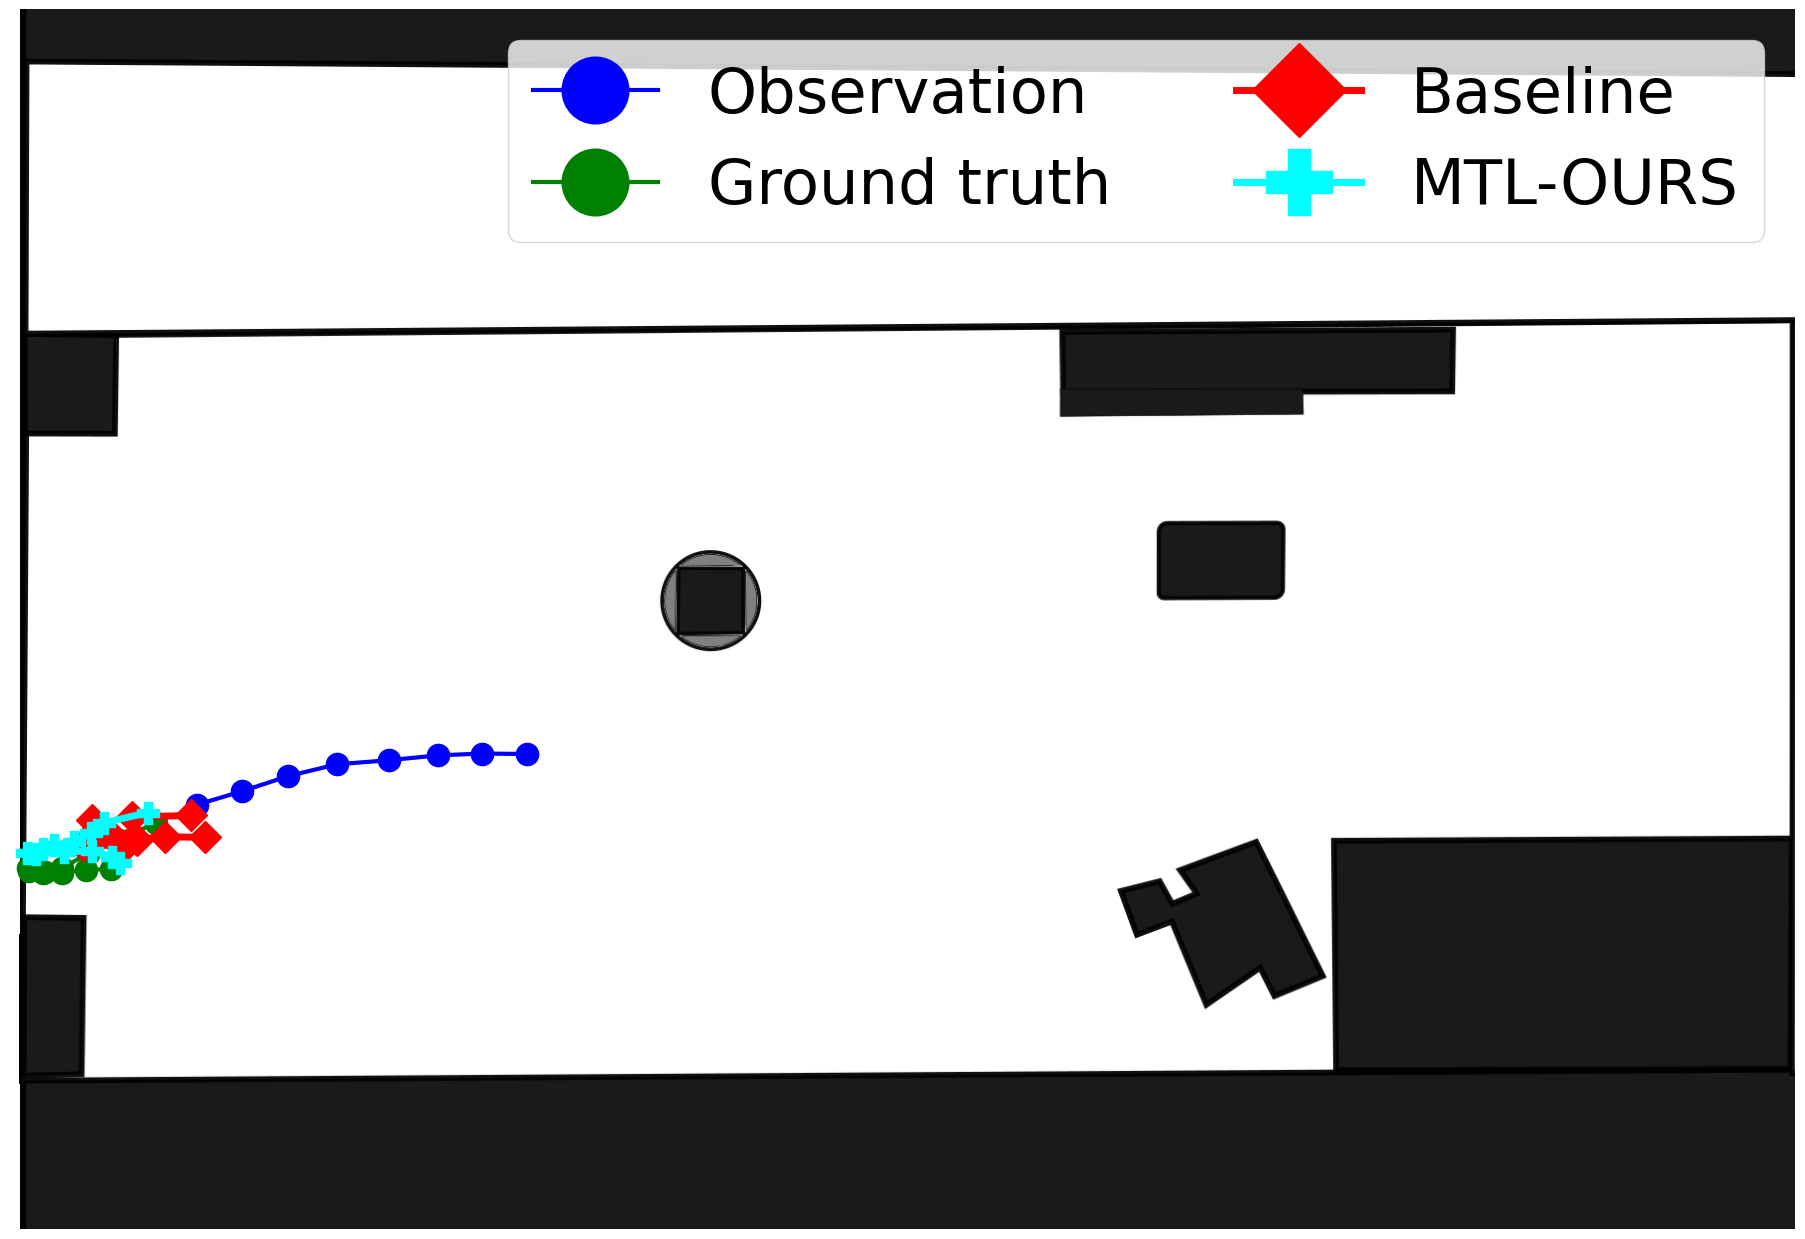

In [91]:
observations_plt = obs_batch[SAMPLE_IDX]
ground_truth_plt = gt_batch[SAMPLE_IDX]

base_pred_plt = base_pred[0][SAMPLE_IDX]
cond_pred_plt = cond_pred[0][SAMPLE_IDX]
mtl_pred_plt = mtl_pred[0][SAMPLE_IDX]

if VISUALS_PATH:
    scenario_id = dataset_batch[SAMPLE_IDX]
    scenario_name = next(
        (
            key
            for key, value in test_dl.dataset.mapping_datasets.items()
            if value == scenario_id
        ),
        None,
    )
    all_maps = os.listdir(VISUALS_PATH)
    target_maps = [
        _map for _map in all_maps if "SC" + scenario_name.split(".png")[0][-1] in _map
    ]
    for tm in target_maps[:1]:
        img = np.array(Image.open(os.path.join(VISUALS_PATH, tm)))
        spatial_layout = np.flipud(img[:, :, :3])
        plt.figure(figsize=(25, 12.5))
        plt.imshow(spatial_layout)
        month = "September" if tm.startswith("3009") else "May"

        obs_pix = pix2word_converters[month].convert2pixels(observations_plt)
        gt_pix = pix2word_converters[month].convert2pixels(ground_truth_plt)
        base_pix = pix2word_converters[month].convert2pixels(base_pred_plt)
        cond_pix = pix2word_converters[month].convert2pixels(cond_pred_plt)
        mtl_pix = pix2word_converters[month].convert2pixels(mtl_pred_plt)

        plot_predictions(obs_pix, gt_pix, base_pix, mtl_pix)
        first_actions_gt = "".join(list(str(gt_actions_class_name[:6]))[:-1] + [","])
        last_actions_gt = "".join(list(str(gt_actions_class_name[6:]))[1:])
        first_actions_pred = "".join(list(str(pred_actions_class_name[:6]))[:-1] + [","])
        last_actions_pred = "".join(list(str(pred_actions_class_name[6:]))[1:])
        # plt.text(
        #     20,
        #     1265,
        #     f"GT actions: {first_actions_gt}",
        #     fontsize=30,
        #     color="green",
        #     weight="bold",
        # )
        # plt.text(
        #     250,
        #     1220,
        #     last_actions_gt,
        #     fontsize=30,
        #     color="green",
        #     weight="bold",
        # )
        # plt.text(
        #     20,
        #     1040,
        #     f"MTL actions: {first_actions_pred}",
        #     fontsize=30,
        #     color="cyan",
        #     weight="bold",
        # )
        # plt.text(
        #     250,
        #     995,
        #     last_actions_pred,
        #     fontsize=30,
        #     color="cyan",
        #     weight="bold",
        # )

        plt.xlim([-10, 1790])
        plt.ylim([500, 1730])
        legend = plt.legend(prop={"size": 45}, markerscale=3, ncols=2)
        plt.savefig("/home/tmr/Downloads/base_mtl_v2.svg")
else:
    plt.figure(figsize=(25, 12.5))
    plot_predictions(observations_plt, ground_truth_plt, base_pred_plt, mtl_pred_plt)